In [126]:
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
import numpy as np

# 1. Preparación Dataset

In [127]:
data = pd.read_csv("data.csv")

In [128]:
tf_count = data["Categoria"].value_counts()
tf_count

Categoria
1    36267
0    26705
Name: count, dtype: int64

In [129]:
data_procesada = data.drop(columns=["id", "Topico", "Fuente", "URL"])
data_procesada

,Categoria,Titulo,Texto,Fecha,Origen
0,1,Moreno intenta apaciguar el flanco sanitario m...,El presidente abre la puerta a unos comicios e...,19/04/2022,Vigo
1,1,La Abogacía del Estado se retira como acusació...,"En un escrito, la abogada del Estado Rosa Marí...",17/09/2021,Vigo
2,0,Las promesas incumplidas de Pablo Echenique en...,Este lunes y martes la Asamblea de Madrid acog...,12/09/2022,Vigo
3,1,Sánchez defiende 'resolver el problema' de la ...,Resulta evidente que la ley ha tenido algunos ...,07/02/2023,Vigo
4,1,Ian Gibson cierra la lista electoral de la con...,"El hispanista, que ya ocupó un puesto simbólic...",12/04/2023,Vigo
...,...,...,...,...,...
62967,0,Madonna será la nueva imagen del Chocolate Abu...,Madonna será la nueva imagen del Chocolate Abu...,NaN,Posadas
62968,1,"Filtran material íntimo de Zelina Vega, luchad...","Filtran material íntimo de Zelina Vega, luchad...",NaN,Posadas
62969,0,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...,CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...,NaN,Posadas
62970,0,TV Azteca anuncia que cambiará su nombre por u...,TV Azteca anuncia que cambiará su nombre por u...,NaN,Posadas


In [131]:
# Elimino los valores nulos de Texto
df_texto = data_procesada[['Categoria', 'Texto']].dropna(subset=['Texto'])

#Elimino los valores nulos de titulo
df_titulo = data_procesada[['Categoria', 'Titulo']].dropna(subset=['Titulo'])


In [132]:
df_titulo = df_titulo.rename(columns={'Titulo': 'Texto'})

In [133]:
df_final = pd.concat([df_texto, df_titulo], ignore_index=True)
df_final.head(10)


,Categoria,Texto
0,1,El presidente abre la puerta a unos comicios e...
1,1,"En un escrito, la abogada del Estado Rosa Marí..."
2,0,Este lunes y martes la Asamblea de Madrid acog...
3,1,Resulta evidente que la ley ha tenido algunos ...
4,1,"El hispanista, que ya ocupó un puesto simbólic..."
5,1,Empieza una intensa semana para el Ejecutivo c...
6,1,Núñez Feijóo guarda silencio pero Ayuso y Alme...
7,1,Los socialistas han remarcado que estos trabaj...
8,1,"El ministro de Inclusión, Seguridad Social y M..."
9,1,Izquierda Unida debate y aprueba este sábado s...


# 2. Modelo

In [6]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Reshape, Flatten, Activation
from keras.layers import Dropout, BatchNormalization, GaussianNoise
from keras.layers import Dense, LSTM
from keras.constraints import max_norm
from keras.optimizers import RMSprop, SGD, Adadelta, Adagrad, Adam


In [7]:
import re
from stop_words import get_stop_words

In [8]:
stop_words_es = get_stop_words('es')
puntuaciones = "'.,;:\"()[]{}\\/?!-_*'"

def quitar_stop_words(texto):
    words = texto.split()
    result_words = [word for word in words if (word not in stop_words_es and word not in puntuaciones)]
    resultado = ' '.join(result_words)
    return resultado

def clean_comments(corpus):
    patt1 = re.compile('\d')
    patt2 = re.compile('\W')
    patt3 = re.compile('  *')

    corpus = corpus.lower()
    corpus = patt1.sub('', corpus)
    corpus = patt2.sub(' ', corpus)
    corpus = patt3.sub(' ', corpus)
    corpus = quitar_stop_words(corpus)
    return corpus

In [148]:
df_final['Texto_Limpio'] = df_final['Texto'].apply(lambda x: clean_comments(x))

In [151]:
corpus = df_final['Texto_Limpio'].values
corpus[0]

'presidente abre puerta comicios junio domingo'

In [152]:
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()
tknzr.tokenize(corpus[0])

['presidente', 'abre', 'puerta', 'comicios', 'junio', 'domingo']

In [153]:
corpus_tk = []
for i in corpus:
    corpus_tk.append(tknzr.tokenize(i))

In [156]:
from gensim.models import Word2Vec
model = Word2Vec(corpus_tk, min_count=50, window=5, vector_size=100)
X = model.wv.vectors
X

array([[ 2.3628967e+00, -1.5226243e+00, -6.6190201e-01, ...,
         5.0152534e-01, -3.0791545e-01,  1.0522318e+00],
       [ 6.2482524e-01, -1.2060798e+00,  4.3250200e-01, ...,
         2.0211432e+00, -1.0729474e+00, -4.9969450e-01],
       [ 3.7906006e-01, -1.4671494e+00, -1.2260612e+00, ...,
        -1.0771688e+00,  2.6818621e+00, -2.7048713e-01],
       ...,
       [-1.5280643e-01, -4.6993453e-02,  7.0503138e-02, ...,
         1.0559133e-01, -1.7473057e-01,  1.6786841e-01],
       [ 1.0777017e-01,  2.6883110e-01,  2.5811156e-03, ...,
        -1.6478501e-01,  3.2521244e-02,  5.9798829e-02],
       [-1.2551068e-01, -3.1751920e-02,  2.1364170e-03, ...,
        -2.5163423e-02,  8.4868617e-02,  7.7502474e-02]], dtype=float32)

Text(0.5, 0, 'PCA Components')

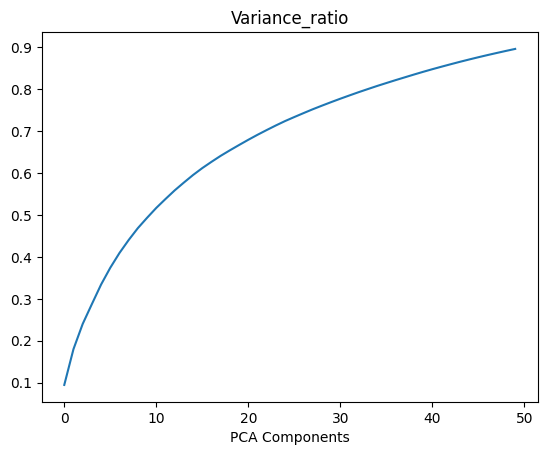

In [157]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, svd_solver='full')
pca.fit(X)
plt.plot((pca.explained_variance_ratio_).cumsum())
plt.title('Variance_ratio')
plt.xlabel('PCA Components')


In [159]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30, svd_solver='full')
pca.fit(X)

PCA(n_components=30, svd_solver='full')

In [160]:
Y = data_procesada['Categoria'].values

tt = int(0.9 * len(X))
X_train, X_test = X[:tt], X[tt:]
y_train, y_test = Y[:tt], Y[tt:]

In [161]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [162]:
x_train, x_test = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]), X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y = np.eye(2)[Y]
Y_train, Y_test = y[:tt], y[tt:]

In [163]:
_tensor_ = input_tensor = Input(shape=(1, x_train.shape[2]), name='main_input')

_tensor_ = LSTM(51, activation='relu', kernel_constraint=max_norm(3.0), return_sequences=True)(_tensor_)

_tensor_ = Flatten()(_tensor_)

_tensor_ = Dense(500, activation='relu', kernel_constraint=max_norm(3.0))(_tensor_)
_tensor_ = Dense(500, activation='relu', kernel_constraint=max_norm(3.0))(_tensor_)
_tensor_ = Dense(100, activation='relu', kernel_constraint=max_norm(3.0))(_tensor_)

output_tensor = Dense(2, activation='sigmoid', kernel_constraint=max_norm(3.0))(_tensor_)

model = Model(input_tensor, output_tensor)
model.compile(loss='mse', optimizer=Adagrad())
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 1, 100)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_8 (LSTM)                   │ (None, 1, 51)             │     31,008 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_8 (Flatten)             │ (None, 51)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_32 (Dense)                │ (None, 500)               │     26,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_33 (Dense)                │ (None, 500)               │    250,500 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_34 (Dense)                │ (None, 100)               │     50,100 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_35 (Dense)                │ (None, 2)                 │        202 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 357,810 (1.36 MB)

 Trainable params: 357,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [207]:
model.fit(x_train, Y_train, batch_size=2048, epochs=10, shuffle=True, verbose=1)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2423
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2423
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2432
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2429
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2422
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2423
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2422
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2419
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2427
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2429


In [208]:
y_pred = np.zeros(y_test.shape[0])
for i,case in enumerate(model.predict(x_test)):
    y_pred[i] = case.argmax()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step


In [209]:
accuracy = (100.0 * (y_test == y_pred).sum()) / len(Y_test)
accuracy

42.5448596341612